In [2]:
"""
BASED ON https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/12-Particle-Filters.ipynb
"""

import numpy as np
from numpy.random import uniform, multivariate_normal, dirichlet, random, randint
from numpy.linalg import norm

from gatherMatrices import getMixtureEmissionMatrices
import pickle

np.set_printoptions(linewidth=100000)

with open("../data/allDF.pickle", "rb") as f:
    df = pickle.load(f)

emissionMatrix, VtoI, ItoV, EtoI = getMixtureEmissionMatrices(df)
print(VtoI)
print(EtoI)

{'bVII': 0, 'IV': 1, 'viio/ii': 2, 'bvii': 3, 'ii': 4, 'vi': 5, 'v': 6, 'iv': 7, 'I': 8, 'iii': 9, 'viio/V': 10, 'i': 11, 'V': 12, 'vii': 13, 'bVI': 14, 'bIII': 15, 'START': -1, 'PAD': -2}
{'anger': 0, 'fear': 1, 'sadness': 2, 'none': 3, 'irony': 4, 'love': 5, 'joy': 6}


In [3]:
def create_uniform_particles(
        a_range, f_range, s_range,
        n_range, i_range,
        l_range, j_range,
        N
):
    particles = np.empty((N, 7))
    for i, (var, range) in enumerate(locals().items()):
        if var[-5:] != "range": break
        particles[:, i] = uniform(range[0], range[1], size=N)
    # for i, row in enumerate(particles):
    #     particles[i, :] = row / sum(row)

    return particles

In [4]:
def predict(particles, phi, constant, epsilon_var, max_alpha=10):
    """
    Move alpha forward one time step according to alpha_t = phi * alpha_t-1 + epsilon
    Note: this operation is in-place
    """
    for i, alpha_t_1 in enumerate(particles):
        while True:
            epsilon = multivariate_normal(
                mean=[0 for _ in range(len(alpha_t_1))],
                cov=np.eye(len(alpha_t_1)) * epsilon_var
            )
            alpha_t = np.matmul(phi, alpha_t_1.T).squeeze() + epsilon + constant
            # print(alpha_t)
            # break
            if np.all(alpha_t > 0) and np.all(alpha_t < max_alpha):
                break

        particles[i, :] = alpha_t


In [5]:
def estimateParticleWeight(alpha: np.array, harmony: int, N=300) -> float:
    """
    Approximate the weight of a given particle associated with a given harmony
    :param alpha: the alpha value associated with the particle
    :param harmony: the observed harmony
    :param N: number of emission particles used to estimate the transition particle weights
    :return: Estimated weight of the given particle
    """
    samples = []
    for _ in range(N):
        p = dirichlet(alpha)
        h_dist = np.matmul(p, emissionMatrix).squeeze()
        h_dist = h_dist / norm(h_dist, ord=1)
        samples.append(h_dist[harmony]) #TODO: check that harmony index is same throughout
    return sum(samples) / len(samples)


def update(particles, harmony, weights, num_emission_particles=300):
    for i, particle in enumerate(particles):
        weights[i] *= estimateParticleWeight(particle, harmony, num_emission_particles)
    weights += 1e-300
    weights /= sum(weights)

In [6]:
def estimate(particles, weights):
    mean = np.average(particles, weights=weights, axis=0)
    var = np.average((particles - mean) ** 2, weights=weights, axis=0)
    # mean = mean / sum(mean)
    return mean, var

In [7]:
def resample(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights.resize(len(particles))
    weights.fill(1.0 / len(weights))

In [8]:
def effective_N(weights):
    return 1.0 / np.sum(np.square(weights))

In [9]:
from filterpy.monte_carlo import systematic_resample
from numpy.random import randn
import scipy.stats
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

def filter_loop(
        particles,
        phi,
        constant,
        epsilon_var,
        max_alpha,
        harmony,
        num_emission_particles,
        num_particles,
        weights
):
    predict(particles, phi, constant, epsilon_var, max_alpha)
    update(particles, harmony, weights, num_emission_particles)

    if effective_N(weights) < num_particles/2:
        indexes = systematic_resample(weights)
        resample(particles, weights, indexes)
        assert np.allclose(weights, 1/num_particles)

    mu, var = estimate(particles, weights)
    return mu, var

def run_filter(
        num_particles: int,
        harmonies: list[int],
        phi: np.array=np.eye(7),
        constant: np.array=np.zeros((7,)),
        epsilon_var=0.1,
        max_alpha=10,
        num_emission_particles=300,
        plot=True,
        burn_in=10
):
    plt.figure()

    particles = create_uniform_particles(
        (0, max_alpha), (0, max_alpha), (0, max_alpha), (0, max_alpha),
        (0, max_alpha), (0, max_alpha), (0, max_alpha),
        num_particles
    )
    weights = np.ones(num_particles) / num_particles

    estimates = []
    for _ in (pbar := tqdm(range(burn_in), total=burn_in)):
        pbar.set_description(f"Burn in for {burn_in} steps")
        filter_loop(particles, phi, constant, epsilon_var, max_alpha, harmonies[0], num_emission_particles, num_particles, weights)
    for i, harmony in (pbar := tqdm(enumerate(harmonies), total=len(harmonies))):
        pbar.set_description(f"Running filter")
        mu, var = filter_loop(particles, phi, constant, epsilon_var, max_alpha, harmony, num_emission_particles, num_particles, weights)
        estimates.append(mu)

    estimates = np.array(estimates)
    print(estimates)
    if plot:
        plt.subplot(2, 1, 1)
        plt.stackplot(
            range(len(harmonies)),
            estimates[:, 0], estimates[:, 1], estimates[:, 2],
            estimates[:, 3], estimates[:, 4], estimates[:, 5], estimates[:, 6]
        )
        plt.subplot(2, 1, 2)
        for col in estimates.T:
            plt.plot(range(len(harmonies)), col, ls=(0, (1, 2)))
        plt.show()



In [10]:
from statsmodels.tsa.api import VAR
import pandas as pd
from timeSeries import loadAlphas, myVAR

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [11]:
alphas: pd.DataFrame = loadAlphas(32, 3)
alphas: pd.DataFrame = alphas.drop(columns=["index"])
phi, constant = myVAR(alphas, set_lag_num=1)
phi /= np.amax(np.abs(phi)) + 1
phi = phi.round(3)
constant /= np.amax(np.abs(constant)) + 1
constant = constant.round(3)
print(phi)
print(constant)

[[ 0.161  0.005  0.004  0.006  0.009  0.089  0.007]
 [-0.005  0.158  0.003  0.001  0.005  0.048  0.005]
 [-0.025 -0.001  0.133 -0.003 -0.003 -0.024  0.001]
 [ 0.175 -0.014  0.042  0.16   0.004 -0.042  0.03 ]
 [ 0.06   0.117  0.082 -0.03   0.063 -0.827 -0.186]
 [-0.015 -0.    -0.012  0.002  0.006  0.215  0.007]
 [-0.019 -0.019 -0.033 -0.004 -0.002 -0.024  0.173]]
[-0.102 -0.06  -0.015  0.031  0.067  0.564  0.11 ]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

[[1.90751566 4.88439895 3.30103744 4.35121036 7.72132509 9.56253028 5.49620385]
 [1.88480986 4.85325001 3.50941663 4.27134881 7.65120529 9.59447845 5.72166248]
 [1.77947904 5.02682727 3.64701483 4.16804783 7.71623583 9.59535936 5.79001771]
 [1.85131598 4.85784901 3.40880749 4.39085372 7.93821114 9.66196727 5.89138889]
 [1.93207855 4.84419878 3.57566678 4.35423968 7.91031625 9.78259327 6.06489061]
 [2.00378544 4.75519499 3.65977303 4.09309747 7.92663434 9.87214223 6.13554512]
 [1.87480642 4.48777511 3.58883452 4.10332501 7.82633645 9.81788802 6.39885273]
 [1.80875935 4.23881286 3.29308908 3.98662079 8.03333636 9.91526732 6.58903308]
 [1.8178832  4.19065008 3.09748643 4.08325883 7.9333473  9.81790123 6.67258314]
 [1.76994816 4.08639954 3.29605945 4.07571478 8.02377674 9.90280493 6.80419009]
 [1.82111363 3.91470479 3.40131435 3.83134515 8.01737019 9.84624071 6.99408501]
 [1.69209818 3.93798841 3.22915623 3.75710528 8.00952819 9.90566282 7.1311405 ]
 [1.6748182  3.89228867 3.35742305 3.883

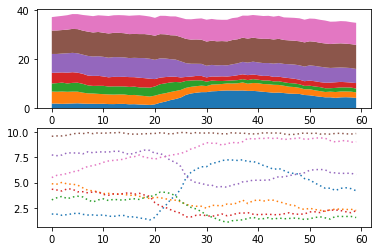

In [14]:
# phi = np.array([
#     [1, 0, 0, 0, 0, 0, 0],
#     [0, 1, 0, 0, 0, 0, 0],
#     [0, 0, 1, 0, 0, 0, 0],
#     [0, 0, 0, 1, 0, 0, 0],
#     [0, 0, 0, 0, 1, 0, 0],
#     [0, 0, 0, 0, 0, 1, 0],
#     [0, 0, 0, 0, 0, 0, 1]
# ])
phi = np.eye(7)
constant = np.zeros((7,))
harmonies = [VtoI["I"] for _ in range(20)] + [VtoI["v"] for _ in range(20)] + [VtoI["I"] for _ in range(20)]
run_filter(
    num_particles=10,
    harmonies=harmonies,
    phi=phi, constant=constant, epsilon_var=0.1,
    max_alpha=10,
    num_emission_particles=10,
    burn_in=10
)

In [13]:
particles = create_uniform_particles(
    (0, 1),
    (0, 1),
    (0, 1),
    (0, 1),
    (0, 1),
    (0, 1),
    (0, 1),
    4
)
print(particles)
predict(particles, np.eye(7), 0.01)
weights = np.array([1/len(particles) for _ in range(len(particles))])
print(particles)
update(particles, 3, weights)
print(weights)
mean, var = estimate(particles, weights)
print(mean)

[[0.46468785 0.05873762 0.58210654 0.54522324 0.32057549 0.23989644 0.57522986]
 [0.33012722 0.20022267 0.38416938 0.96559901 0.40883052 0.96637467 0.80161062]
 [0.75328325 0.41956762 0.97349363 0.79783165 0.76437107 0.42580715 0.10140916]
 [0.92318392 0.1609726  0.84441952 0.43539751 0.30102046 0.22009742 0.87477446]]


TypeError: predict() missing 1 required positional argument: 'epsilon_var'